# 1- Collecting Data from eBay 

## Abstract of Research 

Online third party marketplaces link buyers and sellers by providing a neutral platform for exchange.  However, this requires buyers to assess the quality of goods without being able to handle or sample them.  Recent research has proposed extending the warranting principle, an emerging theory of online interpersonal impression formation, to the judgements consumer make about products online.  The warranting principle holds that *information that is more difficult to manufacture or manipulate, such as an individualized photo of an auction item, should be more informative to a consumers judgement of the product than information which is easy to falsify or manipulate.*  While this theoretical extension assumes that all online goods are capable of being assessed in the same way, some goods (i.e. experience goods) are more difficult to assess in online marketplaces because they must be experienced before their true quality and characteristics can be known.  The current study examines 2,401 completed auctions from eBay revealing that the relationship between warranting cues and price discounts is moderated by the type of good being sold. The theoretical contributions and limitations of the study are discussed. 

### Workflow for eBay project 

- Identify relevant products. 
- Identify eBay ID's for relevant products.
- Collect listings for relevant products.
- Collect images for eBay listings.


In [1]:
__author__ = 'W. Scott Sanders'

import csv
import datetime
import matplotlib.pyplot as plt
import mysql.connector
import pandas as pd
import os 
import requests
import seaborn as sns
import smtplib
import sys 
import traceback
from ebaysdk.exception import ConnectionError
from ebaysdk.finding import Connection
from scipy import stats
from sklearn.cluster import KMeans
from time import sleep

## Identifying Relevant Products

One goal of this study is consider how a uniqueness of information in a product 
listing predicts an items final price at auction.  However, it assumes that 
some products are more difficult to assess than others.  Search goods can be bought 
based on obvious and objective attributes while, in contrast, experience goods are 
assess based on characteristics that cannot be fully known until after purchase.  
Importantly, these variables lay along a continuum, are not truly categorical, and 
there is not agreed upon categorization scheme by researchers. Thus, there is 
need to exploratory analysis to determine if a product is truly an experience or search good.  

1. Prior to collecting data several product types (e.g. headphones, perfume, sunglasses, computer hard drives, etc.) were pilot tested using a survey (N=100) on Mechanical Turk to determine which products consumers felt they could not assess until after purchase (i.e. experience  goods) and which could be bought based on obvious and objective attributes (i.e. search goods).  

2. The mean calculated for the users ability to judge it's quality prior to and after use.  

3. K-means clustering, along with the academic literature, was used to select a subset of products representing search and experience goods.    

In [3]:
# Read in raw data from MTurk. 
df_raw = pd.read_csv('ebay_sec_category_pilot.csv',  index_col='mTurkCode')

# Calculate avg ability to judge product characteristics. 
df_avgs = pd.DataFrame(df_raw.mean(), columns=['score'])

# Split dataset based on judgments prior vs. after purchase. 
mapping = {}
for i in df_avgs.index: 
    _, value = i.split('_')
    
    mapping[i]=value

df_avgs['prior_after']=df_avgs.index.map(mapping)


df_prior = df_avgs.loc[df_avgs['prior_after'] == 'P']
df_after = df_avgs.loc[df_avgs['prior_after'] == 'A']  

# Clean up index names in order to join on index. 
def create_indices_mapping(x): 
    indices = {}

    for i in x: 
            indices[i]=i.split('_')[0]
    
    return indices

prior = create_indices_mapping(df_prior.index)
after = create_indices_mapping(df_after.index)

df_prior, df_after = df_prior.rename(prior), df_after.rename(after)

# Drop columns no longer needed. 
df_prior.drop('prior_after', axis=1, inplace=True)
df_after.drop('prior_after', axis=1, inplace=True)

# Join df's on product (i.e. index) & label columns.
df_evals = df_prior.merge(df_after, how='outer', 
                          left_index=True, right_index=True)
df_evals.columns = ['prior', 'after']

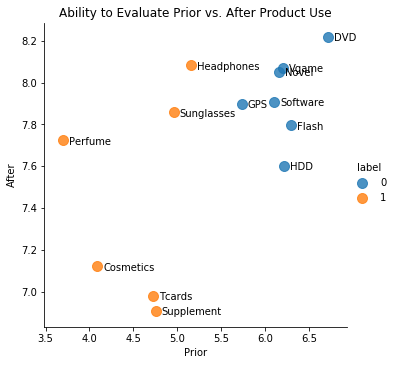

In [4]:
# Cluster using K-means. 
df_evals_std = stats.zscore(df_evals)
kmeans = KMeans(n_clusters=2, random_state=1).fit(df_evals)

df_evals['label']=kmeans.labels_

# Create and label scatter plot of clusters. 
sns.lmplot('prior', 'after', 
           data=df_evals, 
           fit_reg=False, 
           hue="label",  
           scatter_kws={"marker": "D", 
                        "s": 100})

plt.title('Ability to Evaluate Prior vs. After Product Use')
plt.xlabel('Prior')
plt.ylabel('After')


def label_point(x, y, val, ax):
    '''
    See https://stackoverflow.com/questions/46027653
    '''
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.07, point['y']-.02, str(point['val']))

        
label_point(df_evals.prior, df_evals.after, df_evals.index.to_series(),
            plt.gca()) 

## Finding eBay ID's for Products 

This study required the listings for a number of identical products. Fortunately,
the eBay API uses a unique ID number to refer to identical products. Thus, the 
functions below are intended for exploration to discern the relevant category 
and product ids.  The IDs can be subsequently used for automated data collection.

In [ ]:
def create_finding_xml(id_value, id_type="ReferenceID", page_num=1):
    """Creates and returns an xml query for eBay finding API.

    Parameters
    ----------
    id_value : str
        String of the ID number. 
    id_type : str
        The Product ID type. (default="ReferenceID")
    page_num: int
        Results page number. (default=1)

    Returns
    -------
    str
        A valid xml query for eBay finding API.
    """

    xml_query = '<outputSelector>SellerInfo</outputSelector><itemFilter>' \
                '<name>SoldItemsOnly</name><value>true</value>' \
                '</itemFilter><itemFilter><name>ListingType</name>' \
                '<value>Auction</value></itemFilter>' \
                '<paginationInput><entriesPerPage>100</entriesPerPage>' \
                '<pageNumber>{}</pageNumber></paginationInput>' \
                '<productId type="{}">{}</productId>'.format(page_num, id_type,
                                                             id_value)
    return xml_query


def search_finding_api(q):
    """Prints product and category id numbers from ebay finding API. 

    Parameters
    ----------
    q : str or dict
        Takes an xml search string or a dictionary with keys 
        "Keywords": str (required) and "categoryId": int (optional)  
    """

    try:
        finding_api = Connection(config_file='ebay.yaml')

        response = finding_api.execute('findCompletedItems', q)

        results = response.response_dict().searchResult.item

        for result in results:
            try:
                try:
                    print "Product ID:      ", result.productId.value
                    print "Product ID Type: ", result.productId.type

                except:
                    print "No Product ID#."

                print "Product Name:    ", result.title
                print "Item ID:         ", result.itemId
                print "Category ID:     ", result.primaryCategory.categoryId
                print "Category Name:   ", result.primaryCategory.categoryName
                print ''
            except:
                pass

        print "There were {} results for this search.".format(len(results))

    except ConnectionError as e:
        print e
        print e.response.dict()


In [ ]:
# Example Usage
# eBay API queries can be in:
# 1) A dictionary -  {'keywords': str, 'categoryId': int}
# 2) A formated xml string. There is a helper function that helps
#    generate a valid xml query.
query = {
    'keywords': 'bose quietcomfort 25',
    'categoryId': 112529               # Category = Headphones
}

# Uncomment below to search specific product by ReferenceID

#query = create_finding_xml('177603250', "ReferenceID", 1)

search_finding_api(query)

## Collecting Data from Ebay 


Having identified a set of products that represent both experience goods 
(i.e. those that must be experienced to assess) and search goods (i.e. those 
that can be objectively assessed) and discerning their eBay product ID numbers
we need to collect their listings.  eBay provides completed listings for the 
last 90 days which can be stored in a MySQL database.  

**Notes:**
- MySQL credentials and eBay Shopping appid are stored in a seperate json.config file (i.e. *'secrets.json'*).
- There is a create statement for the database used in this script in a seperate file (i.e. *'ebay_sql_create.sql'*).  
- This script runs silently unless there is an issue.  
- We'll be using the following functions from the previous cells: 
    - create_finding_xml()

In [ ]:
def read_config_file(file_name):
    '''Takes json file name as str, returns dict of file contents.
       Used in Python2 to convert unicode json to ascii. 

    Parameters
    ----------
    file_name : str
        Json filename.        

    Returns
    -------
    dict 
        A dictionary of with str in ASCII.  
    '''

    def ascii_encode_dict(data):
        ''' https://stackoverflow.com/q/9590382  
        '''

        def ascii_encode(x): return x.encode(
            'ascii') if isinstance(x, unicode) else x
        return dict(map(ascii_encode, pair) for pair in data.items())

    with open(file_name, 'r') as f:
        config = json.load(f)

    return json.loads(json.dumps(config), object_hook=ascii_encode_dict)


def connect_to_mysql(user, pw, host, database):
    '''Creates connection with mysql database and returns cnx & cursor.

    Parameters
    ----------
    user : str
        MySQL user name.
    pw : str
        MySQL password. 
    host : str
        MySQL hostname or IP address. 
    database : str
        MySQL database name. 

    Returns
    -------
    cnx 
        MySQL connection object.
    cursor
        MySQL cursor object.    
    '''
    cnx = mysql.connector.connect(user=user, password=pw,
                                  host=host, database=database)
    cursor = cnx.cursor()
    return cnx, cursor


def retrieve_from_mysql(query, user, pw, host, db):
    """Retrieves data from MySQL database.  

    Parameters
    ----------
    query : str 
        Valid MySQL query.  
    user : str
        MySQL user name.
    pw : str
        MySQL password. 
    host : str
        MySQL hostname or IP address. 
    database : str
        MySQL database name.

    Returns
    -------
    data: lst of tuples 
        Query results in list of tuples. 
    """
    cnx, cursor = connect_to_mysql(user, pw, host, db)

    cursor.execute(query)

    data = cursor.fetchall()
    cnx.close()
    return data


def str2bool(v):
    '''Takes string represention of bool, returns bool.

    Parameters
    ----------
    v : str

    Returns
    -------
    bool 
    '''
    return v.lower() in ("yes", "true", "t", "1")


def create_shopping_url(ids):
    '''Takes lst of ebay item ids, returns a url query for shopping API.
       Uses eBay shopping appID imported globally from secrets.json

    Parameters
    ----------
    ids : lst of ints
        List of ebay item ids.

    Returns
    -------
    url  : str 
        Url query for eBay shopping API. 
    '''

    url = 'http://open.api.ebay.com/shopping?version=713&appid={}' \
          '&callname=GetMultipleItems&ItemID='.format(SHOPPING_APPID)

    for id in ids:
        url = url + "{},".format(id)

    url = url + '&IncludeSelector=Details,TextDescription' \
                '&ResponseEncodingType=JSON'
    return url


def find_items(finding_api, product, prev_scraped):
    ''' Find new listings, call parsing function, return lst of ebay
        listing ids in str forms. 

    Parameters
    ----------
    finding_api
        eBay api connection object. 
    product: dict 
        dict contains "Name" (productname:str), "Value" (id number-int), 
        & 'Type' (id type:str) 
    prev_scraped: lst of ints
        eBay listing IDs for previously collected listings. 

    Returns
    -------
    new_listed_items: lst of str
        List of ebay item ids as strs. 
    '''

    # Initialize starting parameters for search.
    page_num = 1
    result_length = 100

    # Items not currently in data.
    new_listed_items = []

    while result_length >= 100:
        query = create_finding_xml(product['value'], product['type'], page_num)
        response = finding_api.execute('findCompletedItems', query)
        results = response.response_dict().searchResult.item
        result_length = len(results)
        page_num += 1

        # Parse and add new listed items to MySQL.
        for result in results:
            if int(result.itemId) not in prev_scraped:
                new_listed_items.append(result.itemId)
                parse_finding_results(result, product['name'])

        sleep(3)  # to avoid rate limiting.

    return new_listed_items


# Parse item results from the finding API.
def parse_finding_results(item, name):
    """Takes item data from Finding API, parses it, & add to MySQL.
    
    Parameters
    ----------
    item : dict 
        Item data from eBay FindingAPI
    name : str 
        Product name. 
        
    Returns
    -------
    None
    """
   
    # Adding item information to MySql.
    try:
        postalcode = item.postalCode
    except:
        postalcode = None

    try:
        is_multivariation_listing = str2bool(item.isMultiVariationListing)
    except:
        is_multivariation_listing = None

    try:
        top_rated_listing = str2bool(item.topRatedListing)
    except:
        top_rated_listing = None

    try:
        returns_accepted = str2bool(item.returnsAccepted)
    except:
        returns_accepted = None

    try:
        title = item.title
    except:
        title = None

    try:
        country = item.country
    except:
        country = None

    try:
        bidcount = item.sellingStatus.bidCount
    except:
        bidcount = None

    try:
        location = item.location
    except:
        location = None

    try:
        view_item_url = item.viewItemURL
    except:
        view_item_url = None

    try:
        condition_id = item.condition.conditionId
    except:
        condition_id = None

    try:
        condition_display_name = item.condition.conditionDisplayName
    except:
        condition_display_name = None

    try:
        product_id_type = item.productId._type
    except:
        product_id_type = None

    try:
        product_id_value = item.productId.value
    except:
        product_id_value = None

    add_item = ("INSERT INTO item_finding_api"
                "(itemId, name, isMultivariationListing, topRatedListing, globalId, title, country, currencyId, saleAmount, "
                "bidCount, Location, postalCode, returnsAccepted, viewItemURL, conditionID, conditionDisplayName, "
                "productIdType, productId)"
                "VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)")

    item_data = (item.itemId,
                 name,
                 is_multivariation_listing,
                 top_rated_listing,
                 item.globalId,
                 title,
                 country,
                 item.sellingStatus.currentPrice._currencyId,
                 item.sellingStatus.currentPrice.value,
                 bidcount,
                 location,
                 postalcode,
                 returns_accepted,
                 view_item_url,
                 condition_id,
                 condition_display_name,
                 product_id_type,
                 product_id_value
                )

    try:
        cursor.execute(add_item, item_data)
    except:
        print "Failed to add item ID #{} to database.".format(item.itemId)

    # Adding listing information to MySQL

    try:
        listing_type = item.listingInfo.listingType
    except:
        listing_type = None

    try:
        gift = str2bool(item.listingInfo.gift)
    except:
        gift = None

    try:
        bestOfferEnabled = str2bool(item.listingInfo.bestOfferEnabled)
    except:
        bestOfferEnabled = None

    try:
        buyItNowAvailable = str2bool(item.listingInfo.buyItNowAvailable)
    except:
        buyItNowAvailable = None

    try:
        start_time = item.listingInfo.startTime
    except:
        start_time = None

    try:
        endtime = item.listingInfo.endTime
    except:
        endtime = None

    add_listing = ("INSERT INTO listing"
                   "(itemId, listingType, gift, bestOfferEnabled, buyItNowAvailable, startTime, endTime)"
                   "VALUES(%s, %s, %s, %s, %s, %s, %s)")

    listing_data = (item.itemId, 
                    listing_type, 
                    gift, 
                    bestOfferEnabled,
                    buyItNowAvailable, 
                    start_time, 
                    endtime
                   )

    try:
        cursor.execute(add_listing, listing_data)
    except:
        print "Failed at adding listing data for item ID#{} " \
              "to database.".format(item.itemId)

    # Adding shipping information to MySQL.
    try:
        shipping_currency = item.shippingInfo.shippingServiceCost._currencyId
        shipping_amount = item.shippingInfo.shippingServiceCost.value
    except:
        shipping_currency = None
        shipping_amount = None

    try:
        expeditedShipping = str2bool(item.shippingInfo.expeditedShipping)
    except:
        expeditedShipping = None

    try:
        oneDayShippingAvailable = str2bool(
            item.shippingInfo.oneDayShippingAvailable)
    except:
        oneDayShippingAvailable = None

    try:
        shipping_type = item.shippingInfo.shippingType
    except:
        shipping_type = None

    try:
        handling_time = item.shippingInfo.handlingTime
    except:
        handling_time = None

    try:
        num_ship_to_locations = len(item.shippingInfo.shipToLocations)
    except:
        num_ship_to_locations = None

    add_shipping = ("INSERT INTO shipping"
                    "(itemId, expeditedShipping, shippingType, currencyId, shippingAmount, oneDayShippingAvailable,"
                    "handlingTime, numShipToLocations)"
                    "VALUES(%s, %s, %s, %s, %s, %s, %s, %s)")

    shipping_data = (item.itemId, 
                     expeditedShipping, 
                     shipping_type,
                     shipping_currency, 
                     shipping_amount,
                     oneDayShippingAvailable,
                     handling_time,
                     num_ship_to_locations
                    )

    try:
        cursor.execute(add_shipping, shipping_data)
    except:
        print "Failed at adding shipping data for item ID#{} " \
              "to database.".format(item.itemId)

    # Adding seller information to MySQL.

    try:
        feedback_star = item.sellerInfo.feedbackRatingStar
    except:
        feedback_star = None
    try:
        feedback_percent = item.sellerInfo.positiveFeedbackPercent
    except:
        feedback_percent = None

    try:
        feedback_score = item.sellerInfo.feedbackScore
    except:
        feedback_score = None

    try:
        seller_user_name = item.sellerInfo.sellerUserName
    except:
        seller_user_name = None

    add_seller = ("INSERT INTO seller"
                  "(itemId, feedbackRatingStar, positiveFeedbackPercent, feedbackScore, sellerUserName)"
                  "VALUES(%s, %s, %s, %s, %s)")

    seller_data = (item.itemId, 
                   feedback_star, 
                   feedback_percent,
                   feedback_score, 
                   seller_user_name
                  )

    try:
        cursor.execute(add_seller, seller_data)
    except:
        print "Failed at adding seller data for item ID#{} " \
              "to database.".format(item.itemId)

    cnx.commit()


def get_shopping_results(item_ids):
    """Gets data from shopping API, calls function to add to MySQL.
    
    Parameters
    ----------
    item_ids: lst of strs
        List of ebay item ids as strs. 

    Returns
    -------
    None
    """

    # Pass first 20 IDs or the if < 20 the whole list to query function.
    while len(item_ids) > 0:
        if len(item_ids) > 19:
            items_for_call = item_ids[:19]
            del item_ids[:19]
        else:
            items_for_call = item_ids
            item_ids = []

        # Construct query.
        query = create_shopping_url(items_for_call)

        # Get data from eBay.
        response = requests.get(query)
        json_data = response.json()
        items = json_data['Item']

        # Parse results
        for item in items:
            parse_shopping_results(item)
        
        sleep(3) #Avoids rate limiting.


# Parse item results from the shopping API
def parse_shopping_results(item):
    """Takes item data from shopping API, parses it, & add to MySQL.
    
    Parameters
    ----------
    item : dict 
        Item data from eBay shoppingAPI
        
    Returns
    -------
    None
    """
    
    # Adding photo url to MySQL.
    
    try:
        pic_url = item['PictureURL'][0]
    except:
        pic_url = None

    add_pic = ("INSERT INTO picture"
               "(itemId, pictureURL)"
               "VALUES(%s, %s)")

    pic_data = (item['ItemID'], 
                pic_url
               )

    try:
        cursor.execute(add_pic, pic_data)
    except:
        print "Failed at adding picture url for " \
              "item #{} to database.".format(item['ItemID'])    
    
    # Adding purchaser data to MySQL

    try:
        feedback_private = item['HighBidder']['FeedbackPrivate']
    except:
        feedback_private = None

    try:
        feedback_star = item['HighBidder']['FeedbackRatingStar']
    except:
        feedback_star = None

    try:
        feedback_score = item['HighBidder']['FeedbackScore']
    except:
        feedback_score = None

    try:
        feedback_user_id = item['HighBidder']['UserID']
    except:
        feedback_user_id = None

    add_purchaser = ("INSERT INTO purchaser"
                     "(itemId, feedbackPrivate, feedbackRatingStar, feedbackScore, userId)"
                     "VALUES(%s, %s, %s, %s, %s)")

    purchaser_data = (item['ItemID'], 
                      feedback_private,
                      feedback_star, 
                      feedback_score, 
                      feedback_user_id)

    try:
        cursor.execute(add_purchaser, purchaser_data)
    except:
        print "Failed at adding purchaser data from item ID#{} " \
              "to database.".format(item['ItemID'])

    # Adding shopping API data to MYSQL
    try:
        condition_desc = item['ConditionDescription']
    except:
        condition_desc = None

    try:
        desc = item['Description']
    except:
        desc = None

    try:
        hit_count = item['HitCount']
    except:
        hit_count = None

    add_shopping = ("INSERT INTO item_shopping_api"
                    "(itemId, Autopay, ConditionDescription, Description, HitCount, ListingType)"
                    "VALUES(%s, %s, %s, %s, %s, %s)")

    shopping_data = (item['ItemID'], 
                     item['AutoPay'], 
                     condition_desc, 
                     desc, 
                     hit_count,
                     item['ListingType'])

    try:
        cursor.execute(add_shopping, shopping_data)
    except:
        print "Failed at adding shopping data from item ID#{} " \
              "to database.".format(item['ItemID'])

    cnx.commit()

In [ ]:
# Example Usage of functions in the previous cell.  

if __name__ == '__main__': 
    
    # Read config for credentials
    secrets = read_config_file('secrets.json')

    SHOPPING_APPID = secrets['shopping_appid']

    # Get previously collected listing ids to avoid extra work.
    query = "SELECT DISTINCT(itemId) from item_finding_api"

    item_ids = [i[0] for i in retrieve_from_mysql(query,
                                                  secrets['user'],
                                                  secrets['password'],
                                                  secrets['host'],
                                                  secrets['database'])]

    # Initiate mysql connection
    cnx, cursor = connect_to_mysql(secrets['user'], secrets['password'],
                                   secrets['host'], secrets['database'])

    finding_api = Connection(config_file='ebay.yaml')

    # Note identical products ironically have multiple product ID's on
    # eBay.  Thus, this is a sampling for demonstration only. 
    
    products = [{'name': 'WD Blue HDD',
                 'type': 'ReferenceID',
                 'value': 177603250},
                {'name': 'GTA 5 - Xbox',
                 'type': 'ReferenceID',
                 'value': 77178344},
                {'name': 'Avengers - DVD',
                 'type': 'ReferenceID',
                 'value': 115268628},
                {'name': 'Bose Quietcomfort 15',
                 'type': 'ReferenceID',
                 'value': 171620678},
                {'name': 'Fifty Shades of Grey Trilogy',
                 'type': 'ReferenceID',
                 'value': 117252997},
                {'name': 'Coco Mademoiselle (Eau de Parfum)',
                 'type': 'ReferenceID',
                 'value': 83414821},
                {'name': 'Windows 7 Professional',
                 'type': 'ReferenceID',
                 'value': 127642666},
                ]

    for product in products:
        new_item_ids = find_items(finding_api, product, item_ids)
        get_shopping_results(new_item_ids)

    cnx.close()

# Downloading eBay Listing Photos

One thing we'd like to do is determine if unique photos (i.e. photos not used for multiple listings) contribute to higher sales prices.  This is based on the premise the unique photos are more informative about the actual item consumers are buying than stock photos.  However, in order to analyze the photos we first need to grab them.  

We can download photos using Python's request library.   We'll also use a csv file to create a log so that we can manually review listings where there was an issue downloading the photos.

**Notes:**<br>
We'll be using the following functions from the previous cells: 
    - connect_to_mysql()
    - retrieve_from_mysql()

In [ ]:
def add_to_csv(rows, file_name='no_name.csv', headers=None, dir_name=None):
    '''Outputs a csv file from a list of rows. 

    Parameters
    ----------
    rows : lst of lsts
        Data in lst of lst format. 
    file_name: str 
        CSV filename. 
    headers: lst of strs
        Column headers   
    dir_name: str
        Directory to save file to. (Defaults to working directory)

    Returns
    -------
    None - Outputs csv.  
    '''

    if dir_name is None:
        save_path = os.path.join(os.getcwd(), file_name)
    else:
        save_path = os.path.join(os.path.join(os.getcwd(), dir_name),
                                 file_name)
        # Creates dir if not present.
        if not os.path.isdir(os.path.join(os.getcwd(), dir_name)):
            os.mkdir(os.path.join(os.getcwd(), dir_name))

    # Creates file if not present. .
    if not os.path.exists(save_path):
        print "\nCreating a csv file. \n"

        with open(save_path, "w") as f:
            if headers:
                f_csv = csv.writer(f, delimiter=',', lineterminator='\n')
                f_csv.writerow(headers)
            f.close()

    # Append data to file.
    with open(save_path, "a") as f:
        print "Appending to csv file. \n"
        f_csv = csv.writer(f, delimiter=',', lineterminator='\n')
        f_csv.writerows(rows)
        f.close()

    print "CSV successfuly saved. \n"


def download_photos(photos, dir_name):
    '''Takes string represention of bool, returns bool.

    Parameters
    ----------
    photos : lst of iterables
        List of iterables (i). i[0] is identifier, i[1] is file url.
    dir_name: str 
        Directory name to save downloaded photos. 

    Returns
    -------
    not_downloaded : lst of lst
        Items not downloaded.  i[0] is identifier, i[1] is file url. 
    '''

    save_path = os.path.join(os.getcwd(), dir_name)

    if not os.path.isdir(save_path):
        os.mkdir(os.path.join(os.getcwd(), dir_name))

    not_downloaded = []
    counter = 0

    for photo in photos:
        counter += 1
        try:
            response = requests.get(photo[1])
            full_path = os.path.join(save_path, str(photo[0])+'.jpg')

            if response.status_code == 200:
                f = open(full_path, 'wb')
                f.write(response.content)
                f.close()
                if not counter % 10:
                    print "Successfully downloaded item {}, {} " \
                          "of {}.".format(photo[0], counter, len(photos))
            else:
                not_downloaded.append(photo)

        except:
            not_downloaded.append(photo)

    return not_downloaded

In [ ]:
# Example usage of previous cell's functions. 
if __name__ == '__main__':

    # Read config for credentials
    secrets = read_config_file('secrets.json')

    # Get previously collected listing ids to avoid extra work.
    query = "SELECT * from picture"

    photo_urls = retrieve_from_mysql(query, secrets['user'], 
                                     secrets['password'], secrets['host'], 
                                     secrets['database'])

    # Initiate mysql connection
    cnx, cursor = connect_to_mysql(secrets['user'], secrets['password'],
                                   secrets['host'], secrets['database'])

    # Download Photos
    output_dir_name = 'ebay_listing_photos'
    not_downloaded_urls = download_photos(photo_urls, output_dir_name)

    # Log download errors
    fname = 'not_downloaded.csv'
    headers = ['itemId', 'pictureURL']
    add_to_csv(not_downloaded_urls, fname, headers, output_dir_name)

## Content Analysis - Photo Type

Finally, the most interesting datasets are those that combine information from different sources or, alternatively, are annotated by human beings to discern things that are relatively difficult for computer to do.  Since we're dealing with a relatively small dataset its more effort than it's worth to try to build a classifier.  Instead, we used [content analysis](https://usu.instructure.com/files/67974091/download?download_frd=1&verifier=qSU7xYWottTv6ZBbrn2n9XVCX50rZ9b7EaHVx6Uq) to ensure the reliability of labels for whether the photos represented a **stock photo** or a **user submitted photo**.

Note:  Cases were eliminated during the content coding stage if they displayed more than one product in an image (e.g. auction lots) as it would be impossible to assess how customers valued any given item based on eBay data. 